# Classification to identify subjects

This notebook reproduces plots that appear in Fig. 4 of the paper:

- Gilson M, Zamora-López G, Pallarés V, Adhikari MH, Senden M, Tauste Campo A, Mantini D, Corbetta M, Deco G, Insabato A (submitted) "Model-based whole-brain effective connectivity to study distributed cognition in health and disease", bioRxiv; https://doi.org/10.1101/531830.

The goal of to compare the connectivity measures (in particular, effective versus functional connectivity) in identifying subjects.

It uses the scikit-learn library, see https://scikit-learn.org/ for details and tutorials.

In [1]:
# Toggle to True to create directory and store results there
save_outputs = False
if save_outputs:
    import os
    res_dir = 'classif/'
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)

We load the data and calculate the features: 'EC' stands for effective connectivity (estimated for the MOU model, see the *MOU_EC_Estimation* notebook), 'FC' for the BOLD correlations, 'FC + mask' for the BOLD correlations only concerning the ROI connections that exist according to the structural data (diffusion tensor imaging), 'PC' for the partial correlations.

In [2]:
# Import dependencies
import numpy as np
import scipy.stats as stt
import sklearn.linear_model as skllm
import sklearn.neighbors as sklnn
import sklearn.discriminant_analysis as skda
import sklearn.preprocessing as skppc
import sklearn.pipeline as skppl
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Set data parameters
param_dir = 'model_param_movie/'
n_sub = 22 # number of subjects
n_run = 5  # number of sessions per subject (2 rest + 3 movie)
N = 66     # number of ROIs

# Load data previously generated in notebook 'MOU_EC_Estimation.ipynb'
# Effective connectivity estimated using the MOU dynamic model
EC = np.load(param_dir + 'J_mod.npy')
# Mask of existing connections in SC (structural connectivity)
mask_EC = np.load(param_dir + 'mask_EC.npy')
# BOLD covariances (without time lag)
FC0 = np.load(param_dir + 'FC_emp.npy')[:,:,0,:,:]
# triangular mask to retain half of the matrix elemenets in symmetric matrices
mask_tri = np.tri(N,N,-1, dtype=np.bool)

# Calculate features
for i_sub in range(n_sub):
    for i_run in range(n_run):
        # apply z-scoring to EC
        EC[i_sub,i_run,mask_EC] = stt.zscore(EC[i_sub,i_run,mask_EC])

corr = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        corr[i_sub,i_run,:,:] /= np.sqrt( np.outer(corr[i_sub,i_run,:,:].diagonal(), corr[i_sub,i_run,:,:].diagonal()) )

PC = np.copy(FC0)
for i_sub in range(n_sub):
    for i_run in range(n_run):
        PC[i_sub,i_run,:,:] = -np.linalg.pinv(PC[i_sub,i_run,:,:])
        PC[i_sub,i_run,:,:] /= np.sqrt(np.outer(PC[i_sub,i_run,:,:].diagonal(),PC[i_sub,i_run,:,:].diagonal()))

# Plotting labels for connectivity measures
n_conn = 4
label_conn = ['EC', 'FC', 'FC + mask', 'PC']

The following code repeats the classification by splitting the fMRI sessions into a train set and test set (`n_rep` times). Here 2 sessions are used for training and 3 for testing, the split being randomly performed for each subject.

We compare 2 classifiers:

- MLR is the multinomial logistic regression;
- 1NN is the 1-nearest-neighbor.

See the scikit-learn [website](https://scikit-learn.org/stable/) for details.

Note that the chance level here is equal to `1 / n_sub`, since all subjects have the same number of sessions in the test set.

EC
Mean/std performance MLR: 0.8469696969696969 , 0.12373325080742
Mean/std performance 1NN: 0.8409090909090908 , 0.10078889920947022
FC
Mean/std performance MLR: 0.7378787878787878 , 0.16006914254426952
Mean/std performance 1NN: 0.7136363636363636 , 0.18475531680867144
FC + mask
Mean/std performance MLR: 0.7393939393939395 , 0.16567196282226238
Mean/std performance 1NN: 0.7272727272727273 , 0.15745916432444337
PC
Mean/std performance MLR: 0.9272727272727274 , 0.04876811193766995
Mean/std performance 1NN: 0.8984848484848484 , 0.07546914791158955


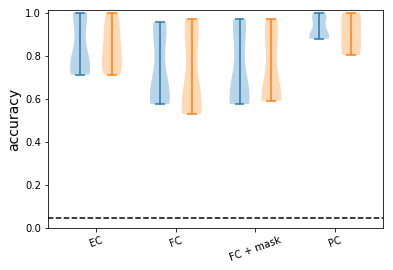

In [4]:
# Classifier and learning parameters
c_MLR = skppl.make_pipeline( skppc.StandardScaler(), skllm.LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='lbfgs', max_iter=500) )
c_1NN = sklnn.KNeighborsClassifier(n_neighbors=1, algorithm='brute', metric='correlation')

# Labels of sessions for classification
sub_labels = np.repeat(np.arange(n_sub).reshape([-1,1]), n_run, axis=1)

# chance level
chance_level = 1. / n_sub

# store results
n_rep = 10  # number of repetition of classification procedure
perf = np.zeros([n_rep,n_conn,2])          # last index: MLR/1NN
CM = np.zeros([n_rep,n_conn,n_sub,n_sub], dtype=np.float)  # confusion matrices
 

# repeat classification
for i_rep in range(n_rep):
    # split indices in train and test sets (2 sessions are randomly chosen for each subject)
    train_ind = np.zeros([n_sub,n_run], dtype=bool)
    for i_sub in range(n_sub):
        while train_ind[i_sub,:].sum()<2:
            train_ind[:,np.random.randint(n_run)] = True
    test_ind = np.logical_not(train_ind)

    # loop over connectivity measures
    for i_conn in range(n_conn):

        if i_conn==0:
            # vectorized EC matrices (only retaining existing connections)
            vect_features = EC[:,:,mask_EC]
        elif i_conn==1:
            # vectorized FC matrices (only retaining low triangle)
            vect_features = corr[:,:,mask_tri]
        elif i_conn==2:
            # vectorized FC matrices (only retaining SC existing connections)
            vect_features = corr[:,:,mask_EC] 
        else:
            # vectorized PC  matrices (only retaining low triangle)
            vect_features = PC[:,:,mask_tri]

        # train and test classifiers with subject labels
        c_MLR.fit(vect_features[train_ind,:], sub_labels[train_ind])
        perf[i_rep,i_conn,0] = c_MLR.score(vect_features[test_ind,:], sub_labels[test_ind])

        c_1NN.fit(vect_features[train_ind,:], sub_labels[train_ind])
        perf[i_rep,i_conn,1] = c_1NN.score(vect_features[test_ind,:], sub_labels[test_ind])

        # confusion matrix for MLR
        CM[i_rep,i_conn,:,:] = skm.confusion_matrix( y_true=sub_labels[test_ind], y_pred=c_MLR.predict(vect_features[test_ind,:]) )

# Save results
if save_outputs:
    np.save(res_dir + 'perf_subs.npy', perf)

# Print and plot summary of performance
for i_conn in range(n_conn):
    print(label_conn[i_conn])
    print('Mean/std performance MLR:', perf[:,i_conn,0].mean(), ',', perf[:,i_conn,0].std())
    print('Mean/std performance 1NN:', perf[:,i_conn,1].mean(), ',', perf[:,i_conn,1].std())

plt.figure()
plt.violinplot( perf[:,:,0], positions=np.arange(n_conn)-0.2, widths=[0.25]*n_conn )
plt.violinplot( perf[:,:,1], positions=np.arange(n_conn)+0.2, widths=[0.25]*n_conn )
plt.plot([-1,n_conn],[chance_level]*2,'--k')
plt.axis(xmin=-0.6, xmax=n_conn-0.4, ymin=0, ymax=1.01)
plt.xticks(range(n_conn), label_conn, rotation=20)
plt.ylabel('accuracy', fontsize=14)
if save_outputs:
    plt.savefig(res_dir + 'perf_sub.png', format='png')

plt.show()

<br>

Confusion matrices are useful to understand the errors performed by the train classifier on the test set. Each row represents the classification of a test sample, with the diagonal element corresponding to the correct classification and off-diagonal elements to errors.

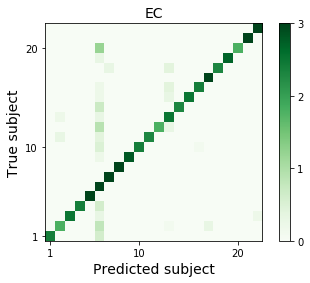

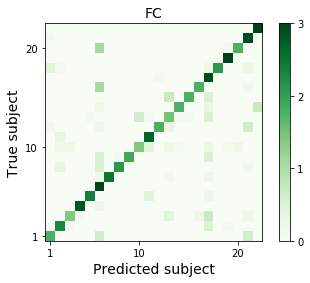

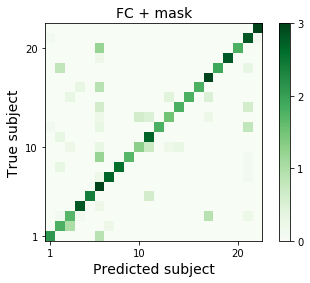

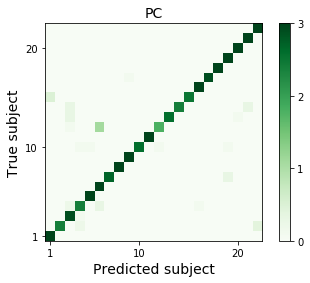

In [5]:
# Plot the confusion matrices
for i_conn in range(n_conn):
    tag = label_conn[i_conn] + '_'
    
    plt.figure()
    plt.imshow(CM[:,i_conn,:,:].mean(0), origin='bottom', cmap='Greens', vmin=0, vmax=3)
    plt.xticks([0,9,19], [1,10,20])
    plt.yticks([0,9,19], [1,10,20])
    plt.xlabel('Predicted subject', fontsize=14)
    plt.ylabel('True subject', fontsize=14)
    plt.colorbar(ticks=range(4))
    plt.title(tag[:-1], fontsize=14)
    if save_outputs:
        plt.savefig(res_dir + 'conf_mat_' + tag + 'sub.png', format='png')